## Hugging face

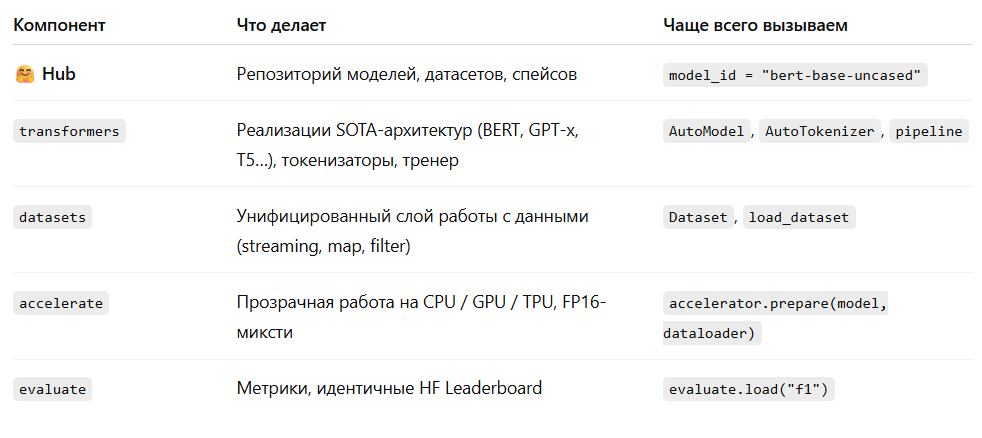

**Ключевые паттерны API**

* **`from_pretrained()`** — загружает веса/словари с 🤗 Hub (локальный кэш).
* **`Auto*`-классы** — динамически подбирают нужную реализацию по `config.json` модели.
* **`pipeline()`** — всё-в-одном для инференса.
* **`Trainer`** — высокоуровневый training loop с логированием, сохранением чекпойнтов, early-stopping, мульти-GPU.
* **`TrainingArguments`** — всё про расписание обучения, бачи, mixed-precision, evaluation-strategy.

## Encoder

In [ ]:
# !pip install transformers[torch] datasets

In [ ]:
import pandas as pd
import numpy as np
import re # работа с регулярными выражениями (очистка текста)
import string

# Импорт библиотеки NLTK для работы с текстом
import nltk
from nltk.corpus import stopwords

from datasets import Dataset

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

In [ ]:
# Ноутбук запускался в среде kaggle, поэтому данные загружались напрямую с датасета

df = pd.read_csv('/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')

### Данные

Работать будем со следующими данными: [Women's E-Commerce Clothing Reviews](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

Датасет содержит 23 486 строк и 10 признаков. Каждая строка соответствует одному пользовательскому отзыву и включает следующие переменные:

* **Clothing ID** — целочисленная категориальная переменная, указывающая на конкретный предмет одежды, к которому относится отзыв.
* **Age** — положительное целое число, возраст автора отзыва.
* **Title** — строковая переменная, заголовок отзыва.
* **Review Text** — строковая переменная, основная часть отзыва.
* **Rating** — порядковая целочисленная переменная от 1 (хуже всего) до 5 (лучше всего), отражающая оценку товара, выставленную покупателем.
* **Recommended IND** — бинарная переменная: 1 — товар рекомендован, 0 — не рекомендован.
* **Positive Feedback Count** — положительное целое число, количество других пользователей, которые нашли отзыв полезным.
* **Division Name** — категориальное наименование верхнего уровня товарного раздела.
* **Department Name** — категориальное наименование товарного отдела.
* **Class Name** — категориальное наименование товарной категории.


### Предобработка корпуса текста

In [ ]:
# Очистка
def clean_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(f'[{string.punctuation}]', '', text)  # Удаление пунктуации
    text = re.sub('\n', ' ', text)  # Удаление переносов строк
    text = re.sub('\d+', '', text)  # Удаление цифр
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Удаление стоп-слов
    return text

# Удаление строк с пустыми отзывами
df.dropna(subset=['Review Text'], inplace=True)

# Стоп-слова
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df['Cleaned Review'] = df['Review Text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Cleaned Review
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful silky sexy comfortable
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretty happened find store im ...
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hopes dress really wanted work initially ...
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit fun flirty fabulous ev...
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flattering due adjustable front tie perf...
...,...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses,happy snag dress great price easy slip flatter...
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits,reminds maternity clothes soft stretchy shiny ...
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses,fit well top see never would worked im glad ab...
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses,bought dress wedding summer cute unfortunately...


In [ ]:
df[['Review Text', 'Cleaned Review']].head()

,Review Text,Cleaned Review
0,Absolutely wonderful - silky and sexy and comf...,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,love dress sooo pretty happened find store im ...
2,I had such high hopes for this dress and reall...,high hopes dress really wanted work initially ...
3,"I love, love, love this jumpsuit. it's fun, fl...",love love love jumpsuit fun flirty fabulous ev...
4,This shirt is very flattering to all due to th...,shirt flattering due adjustable front tie perf...


In [ ]:
# Дублированные функции: токенизация и подсчет метрик

def tokenize_function(examples):
    return tokenizer(examples['Cleaned Review'], padding='max_length', truncation=True, max_length=128)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'f1': f1_score(labels, predictions)}

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Recommended IND'], random_state=42)

### BERT (bert-base-uncased)


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(['Review Text', 'Title', 'Cleaned Review', '__index_level_0__'])
val_dataset = val_dataset.remove_columns(['Review Text', 'Title', 'Cleaned Review', '__index_level_0__'])

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Recommended IND'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Recommended IND'])

# Меняем название, поскольку модель ожидает название "labels"
train_dataset = train_dataset.rename_column('Recommended IND', 'labels')
val_dataset = val_dataset.rename_column('Recommended IND', 'labels')

2024-06-15 15:14:20.087673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 15:14:20.087776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 15:14:20.179761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/18112 [00:00<?, ? examples/s]

Map:   0%|          | 0/4529 [00:00<?, ? examples/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir='./results/BaseBert',
    num_train_epochs=3, # количество эпох - полных проходов по тренировочным данным
    per_device_train_batch_size=8, # размер батча на одно устройство (GPU/CPU)
    per_device_eval_batch_size=8,
    warmup_steps=500, # количество шагов "разогрева" - постепенное увеличение learning rate в начале обучения
    weight_decay=0.01, # L2-регуляризация для весов модели - для борьбы с переобучением
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to q

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,0.297800,0.318604,0.934022
2,0.218400,0.276626,0.936336
3,0.147400,0.338514,0.937097


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

{'eval_loss': 0.33851441740989685,
 'eval_f1': 0.9370967741935483,
 'eval_runtime': 26.1518,
 'eval_samples_per_second': 173.181,
 'eval_steps_per_second': 10.86,
 'epoch': 3.0}

### RoBERTa (roberta-base)

In [ ]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/18112 [00:00<?, ? examples/s]

Map:   0%|          | 0/4529 [00:00<?, ? examples/s]

In [ ]:
train_dataset = train_dataset.remove_columns(['Review Text', 'Title', 'Cleaned Review', '__index_level_0__'])
val_dataset = val_dataset.remove_columns(['Review Text', 'Title', 'Cleaned Review', '__index_level_0__'])

train_dataset = train_dataset.rename_column('Recommended IND', 'labels')
val_dataset = val_dataset.rename_column('Recommended IND', 'labels')

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

training_args = TrainingArguments(
    output_dir='./results/RoBERT',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,0.404600,0.453370,0.901118
2,0.450500,0.471280,0.901532
3,0.452900,0.387495,0.920233


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

{'eval_loss': 0.3874953091144562,
 'eval_f1': 0.9202327084680025,
 'eval_runtime': 27.737,
 'eval_samples_per_second': 163.284,
 'eval_steps_per_second': 10.239,
 'epoch': 3.0}




### DistilBERT (distilbert-base-uncased)

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Загрузка токенизатора и модели DistilBERT
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column('Recommended IND', 'labels')
val_dataset = val_dataset.rename_column('Recommended IND', 'labels')

columns_to_remove = ['Review Text', 'Title', 'Cleaned Review', '__index_level_0__']
train_dataset = train_dataset.remove_columns([col for col in columns_to_remove if col in train_dataset.column_names])
val_dataset = val_dataset.remove_columns([col for col in columns_to_remove if col in val_dataset.column_names])

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

training_args = TrainingArguments(
    output_dir='./results/DistilBERT',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/18112 [00:00<?, ? examples/s]

Map:   0%|          | 0/4529 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1
1,0.303600,0.287800,0.930170
2,0.234600,0.328780,0.935275
3,0.156800,0.390887,0.935925


{'eval_loss': 0.39088666439056396,
 'eval_f1': 0.9359249329758713,
 'eval_runtime': 10.1622,
 'eval_samples_per_second': 445.671,
 'eval_steps_per_second': 55.795,
 'epoch': 3.0}

### Общий пайплайн - пример

In [ ]:
from transformers import (
    AutoTokenizer,         # общий класс-фабрика для всех токенизаторов
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
)

In [ ]:
args = TrainingArguments(
    output_dir="checkpoints",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    warmup_ratio=0.1, # первые 10 % шагов — линейный разогрев learning-rate
    weight_decay=0.01,
    fp16=True # mixed-precision (FP16) ускоряет и экономит память

data_collator = DataCollatorWithPadding(tokenizer=None, return_tensors="pt")  # токенизатор зададим позже


model_names = {
    "BERT-base": "bert-base-uncased",
    "RoBERTa-base": "roberta-base",
    "DistilBERT-base": "distilbert-base-uncased",
}

results = {}
for label, model_id in model_names.items():
    print(f"\n {label} ")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenized_train = train_ds.map(lambda x: tokenize(x, tokenizer), batched=True, remove_columns=["text"])
    tokenized_val = val_ds.map(lambda x: tokenize(x, tokenizer), batched=True, remove_columns=["text"])
    data_collator.tokenizer = tokenizer  # обновим паддинг к актуальному токенизатору

    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    eval_res = trainer.evaluate()
    results[label] = eval_res["eval_f1"]

print(pd.Series(results, name="F1-score").sort_values(ascending=False))

### Предсказываем рейтинг

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # используем 'weighted' для многоклассовой задачи
    return {'f1': f1_score(labels, predictions, average='weighted')}

In [ ]:
# Преобразование рейтинга в диапазон 0-4, поскольку модель работает с метками,
# которые начинаются с нуля

df['Rating'] = df['Rating'] - 1

# Работать будем с базовой Бертой для удобства
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Rating'], random_state=42)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(['Review Text', 'Title', 'Cleaned Review', '__index_level_0__'])
val_dataset = val_dataset.remove_columns(['Review Text', 'Title', 'Cleaned Review', '__index_level_0__'])

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Rating'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Rating'])

train_dataset = train_dataset.rename_column('Rating', 'labels')
val_dataset = val_dataset.rename_column('Rating', 'labels')

training_args = TrainingArguments(
    output_dir='./results/BaseBert_2',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/18112 [00:00<?, ? examples/s]

Map:   0%|          | 0/4529 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1
1,0.869800,0.910136,0.565748
2,0.743800,0.926729,0.618988
3,0.537900,1.037795,0.634552


{'eval_loss': 1.0377954244613647,
 'eval_f1': 0.6345516973688746,
 'eval_runtime': 18.5346,
 'eval_samples_per_second': 244.354,
 'eval_steps_per_second': 30.591,
 'epoch': 3.0}